In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time

Text(0, 0.5, 'life expecatancy')

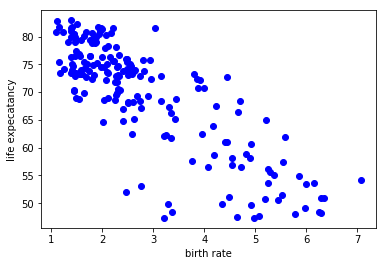

In [2]:
# 导入数据，可视化

data = np.loadtxt('birth_life_2010.txt', dtype = 'f4', delimiter='\t', skiprows=1, usecols=(1, 2))
n_samples = len(data)

plt.plot(data[:, 0], data[:, 1], 'bo', label='Real data')
plt.xlabel('birth rate')
plt.ylabel('life expecatancy')

In [3]:
# huber损失

def huber_loss(labels, predictions, delta=14.0):
    residual = tf.abs(labels - predictions)
    def f1(): return 0.5*tf.square(residual)
    def f2(): return delta*residual - 0.5*tf.square(delta)
    
    return tf.cond(residual<delta, f1, f2)

In [5]:
# 建模

# X = tf.placeholder(tf.float32, name='X') # 创建placeholder
# Y = tf.placeholder(tf.float32, name='Y')
dataset = tf.data.Dataset.from_tensor_slices((data[:, 0], data[:, 1])) # 使用tf.data导入数据
iterator = dataset.make_initializable_iterator()
X, Y = iterator.get_next()

w = tf.get_variable('weights', initializer=tf.constant(0.0)) # 创建w、b，初始化为0
b = tf.get_variable('bias', initializer=tf.constant(0.0))
Y_predicted = w*X + b # 线性模型
loss = tf.square(Y - Y_predicted, name = 'loss') # 均方损失

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss) # 梯度下降

w_huber = tf.get_variable('weights_huber', initializer=tf.constant(0.0)) 
b_huber = tf.get_variable('bias_huber', initializer=tf.constant(0.0))
Y_predicted_huber = w_huber*X + b_huber # 线性模型
loss_huber = huber_loss(labels=Y, predictions=Y_predicted_huber)

optimizer_huber = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss_huber) 

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# 训练

start = time.time()
writer = tf.summary.FileWriter('./graphs/linear_reg', tf.get_default_graph()) # 生成graphs
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # variables初始化
    
    for i in range(100): # 开始训练
        sess.run(iterator.initializer) # 初始化迭代器
        total_loss = 0
        total_loss_h = 0
        try:
            while True:
            # _, _, l, l_h = sess.run([optimizer, optimizer_huber, loss, loss_huber], feed_dict={X:x, Y:y})
                _, _, l, l_h = sess.run([optimizer, optimizer_huber, loss, loss_huber]) 
                total_loss += l
                total_loss_h += l_h
        except tf.errors.OutOfRangeError:
            pass
            
        if i % 10 == 0:
            print('Epoch {0}: {1} {2}'.format(i, total_loss/n_samples, total_loss_h/n_samples))
        
    writer.close()
    w_out, b_out = sess.run([w, b]) # 输出w,b
    w_out_h, b_out_h = sess.run([w_huber, b_huber])

print('Took: %f seconds' %(time.time() - start))

Epoch 0: 1661.863764550287 712.5349932218853
Epoch 10: 335.55436177954664 315.6941960449968
Epoch 20: 119.20935661137888 262.2604390375855
Epoch 30: 55.77163058824279 211.41857506291646
Epoch 40: 37.305592010505066 162.8461132945983
Epoch 50: 32.004961317298495 117.53008066379407
Epoch 60: 30.524589418089263 78.81007368673913
Epoch 70: 30.134226098457216 50.44132069787501
Epoch 80: 30.04458791257593 33.14079166570399
Epoch 90: 30.03209388247043 24.01969862843781
Took: 19.712241 seconds


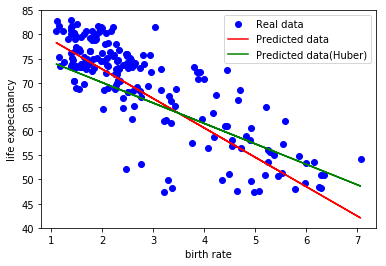

In [8]:
# 可视化

plt.plot(data[:, 0], data[:, 1], 'bo', label='Real data')
plt.plot(data[:, 0], data[:, 0] * w_out + b_out, 'r', label='Predicted data')
plt.plot(data[:, 0], data[:, 0] * w_out_h + b_out_h, 'g', label='Predicted data(Huber)')
plt.xlabel('birth rate')
plt.ylabel('life expecatancy')
plt.legend()